In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

ModuleNotFoundError: No module named 'torch'

Data generated!
Training data shape: (2000, 4)
True Parameters to recover: D=0.1, r=1.0


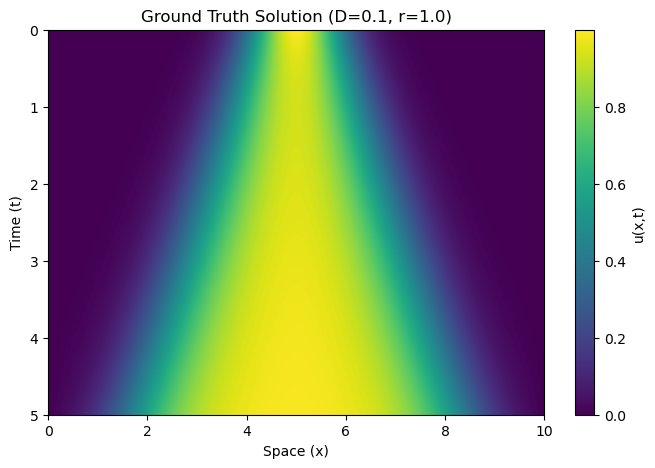

In [4]:
# Forward "True" Solver

D_true = 0.1  # Diffusion coefficient
r_true = 1.0  # Reaction rate

# Relevant Domain
L = 10.0      # Length of domain (e.g., x from 0 to 10)
T = 5.0       # Total time (e.g., t from 0 to 5)
Nx = 200      # Spatial resolution
Nt = 200      # Temporal resolution

# Noise and Sparsity
noise_level = 0.05  # 5% random noise
num_train_samples = 2000 

# Solver
x = np.linspace(0, L, Nx)
t = np.linspace(0, T, Nt)
dx = x[1] - x[0]

# Initial Condition: A Gaussian pulse centered in the domain
u0 = np.exp(-(x - L/2)**2)

def kpp_rhs(u, t, D, r, dx):
    """This is a true forward solver for the KPP-Fisher equation.

    Args:
        u (array): solution
        t (scalar): time
        D (scalar): diffusion coefficient
        r (scalar): reaction state
        dx (scalar): step size

    Returns:
        array: full solution at each time step
    """
    # Finite difference approximation for u_xx
    # u_xx approx (u[i+1] - 2u[i] + u[i-1]) / dx^2
    # We assume Dirichlet BCs (u=0 at boundaries)

    dudt = np.zeros_like(u)
    
    # Laplacian (Diffusion)
    diffusion = D * (u[2:] - 2*u[1:-1] + u[:-2]) / dx**2
    
    # Reaction: r * u * (1 - u)
    reaction = r * u[1:-1] * (1 - u[1:-1])
    
    dudt[1:-1] = diffusion + reaction
    return dudt

# Solve the PDE
solution = odeint(kpp_rhs, u0, t, args=(D_true, r_true, dx))

# Label Data for Feeding into Neural Network

# Create meshgrid to associate every u value with an (x, t) coordinate
X_grid, T_grid = np.meshgrid(x, t)

# Flatten data for export
x_flat = X_grid.flatten()
t_flat = T_grid.flatten()
u_flat = solution.flatten()

# Add Noise
u_noisy = u_flat + noise_level * np.std(u_flat) * np.random.randn(len(u_flat))

# Create a DataFrame
df = pd.DataFrame({
    't': t_flat,
    'x': x_flat,
    'u_exact': u_flat,
    'u_noisy': u_noisy
})

# --- Sparsity (Subsampling) ---
# Randomly sample 'num_train_samples' points for training
train_df = df.sample(n=num_train_samples, random_state=42)

# Save the files
train_df.to_csv("kpp_training_data.csv", index=False)

print("Data generated!")
print(f"Training data shape: {train_df.shape}")
print(f"True Parameters to recover: D={D_true}, r={r_true}")

# Visualize the ground truth
plt.figure(figsize=(8, 5))
plt.imshow(solution, aspect='auto', extent=[0, L, T, 0], cmap='viridis', origin='upper')
plt.colorbar(label='u(x,t)')
plt.title(f"Ground Truth Solution (D={D_true}, r={r_true})")
plt.xlabel("Space (x)")
plt.ylabel("Time (t)")
plt.show()